In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP import confusion_table
from sklearn.metrics import accuracy_score, classification_report, auc, roc_curve,roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# **Predicting heart disease via SVM: the Heart data**

## Load data and pre-processing

In [3]:
Heart = pd.read_csv('Heart.csv') #load the Heart dataset
Heart

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,typical,110,264,0,0,132,0,1.2,2,0.0,reversable,Yes
299,68,1,asymptomatic,144,193,1,0,141,0,3.4,2,2.0,reversable,Yes
300,57,1,asymptomatic,130,131,0,0,115,1,1.2,2,1.0,reversable,Yes
301,57,0,nontypical,130,236,0,2,174,0,0.0,2,1.0,normal,Yes


In [4]:
Heart.dropna(inplace=True) # drop rows with NAs, and replace the original dataframe

In [5]:
Heart.isnull().values.any() # check if there are any NaNs

np.False_

In [6]:
# apply one hot encoding on categorical columns
Heart_transformed = pd.get_dummies(Heart, columns = ['ChestPain','Thal'])
Heart_transformed

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,AHD,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable
0,63,1,145,233,1,2,150,0,2.3,3,0.0,No,False,False,False,True,True,False,False
1,67,1,160,286,0,2,108,1,1.5,2,3.0,Yes,True,False,False,False,False,True,False
2,67,1,120,229,0,2,129,1,2.6,2,2.0,Yes,True,False,False,False,False,False,True
3,37,1,130,250,0,0,187,0,3.5,3,0.0,No,False,True,False,False,False,True,False
4,41,0,130,204,0,2,172,0,1.4,1,0.0,No,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57,0,140,241,0,0,123,1,0.2,2,0.0,Yes,True,False,False,False,False,False,True
298,45,1,110,264,0,0,132,0,1.2,2,0.0,Yes,False,False,False,True,False,False,True
299,68,1,144,193,1,0,141,0,3.4,2,2.0,Yes,True,False,False,False,False,False,True
300,57,1,130,131,0,0,115,1,1.2,2,1.0,Yes,True,False,False,False,False,False,True


In [67]:
# transform labels to numerical values, to enable roc_curve function
Heart_transformed.AHD.replace(('Yes', 'No'), (1, -1), inplace=True)

## Use SVM to predict heart disease

In [7]:
# randomly split to training/test sets
X_train, X_test, y_train, y_test = train_test_split(Heart_transformed.loc[:, Heart_transformed.columns != 'AHD'], Heart_transformed.AHD, test_size=0.30, random_state=105)

In [8]:
scaler = StandardScaler(with_mean=True, with_std=True, copy=True) #scale training and test features
scaler.fit(X_train) #note here we use mean and std of training data to scale training and test data
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [9]:
# apply SVM with RBF kernel and tune gamma and C
tuned_parameters_rbf = [{"kernel": ["rbf"], "gamma": [1,1e-1,1e-2,1e-3, 1e-4], "C": [1, 10, 100,1000]}]
svmCV = GridSearchCV(SVC(), tuned_parameters_rbf, scoring='accuracy',cv=5)
svmCV.fit(X_train_sc, y_train)
print("Best parameters set found on development set:")
print()
print(svmCV.best_params_)
print()
print("Grid scores on development set:")
print()
means = svmCV.cv_results_["mean_test_score"]
stds = svmCV.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, svmCV.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std, params))

Best parameters set found on development set:

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.565 (+/-0.017) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.811 (+/-0.048) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.831 (+/-0.055) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.831 (+/-0.040) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.556 (+/-0.007) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.575 (+/-0.036) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.754 (+/-0.028) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.802 (+/-0.042) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.812 (+/-0.051) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.831 (+/-0.040) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.575 (+/-0.036) for {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
0.754 (+/-0.028) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.787 (+/-0.019) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.836 (+/-0.051) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

In [10]:
# predict test set labels
ypred_cv = svmCV.predict(X_test_sc)
accuracy_score(y_test,ypred_cv)

0.8

In [11]:
confusion_table(ypred_cv, y_test)

Truth,No,Yes
Predicted,,
No,38,11
Yes,7,34


## Study the effect of $\gamma$

We use three values of $\gamma$ to train SVM, and plot ROC curves on both training and test sets.

In [13]:
y_train = y_train.map({'No': 0, 'Yes': 1})
y_test  = y_test.map({'No': 0, 'Yes': 1})
# gamma = 0.001, which is chosen by CV
svmCVl = SVC(kernel='rbf',C=100,gamma=0.001,probability=True).fit(X_train_sc,y_train)
# obtain training fpr, tpr for training set
ytrain_CV = svmCVl.predict_proba(X_train_sc)
fpr_train_CV, tpr_train_CV, threshold_train_CV = roc_curve(y_train, ytrain_CV[:, 1])
auc_train_CV = auc(fpr_train_CV, tpr_train_CV)
print('Training AUC',auc_train_CV)
# obtain training fpr, tpr for test set
ytest_CV = svmCVl.predict_proba(X_test_sc) #obtain ROC curve and AUC value
fpr_test_CV, tpr_test_CV, threshold_test_CV = roc_curve(y_test, ytest_CV[:, 1])
auc_test_CV = auc(fpr_test_CV, tpr_test_CV)
print('Test AUC',auc_test_CV)

Training AUC 0.9465973534971646
Test AUC 0.8940740740740741


In [14]:
# gamma = 0.01
svm02 = SVC(kernel='rbf',C=100,gamma=0.01,probability=True).fit(X_train_sc,y_train)
# obtain training fpr, tpr for training set
ytrain_02 = svm02.predict_proba(X_train_sc)
fpr_train_02, tpr_train_02, threshold_train_02 = roc_curve(y_train, ytrain_02[:, 1])
auc_train_02 = auc(fpr_train_02, tpr_train_02)
print('Training AUC',auc_train_02)
# obtain training fpr, tpr for test set
ytest_02 = svmCVl.predict_proba(X_test_sc) #obtain ROC curve and AUC value
fpr_test_02, tpr_test_02, threshold_test_02 = roc_curve(y_test, ytest_02[:, 1])
auc_test_02 = auc(fpr_test_02, tpr_test_02)
print('Test AUC',auc_test_02)

Training AUC 0.9915879017013232
Test AUC 0.8940740740740741


In [15]:
# gamma = 0.0001
svm04 = SVC(kernel='rbf',C=100,gamma=0.0001,probability=True).fit(X_train_sc,y_train)
# obtain training fpr, tpr for training set
ytrain_04 = svm04.predict_proba(X_train_sc)
fpr_train_04, tpr_train_04, threshold_train_04 = roc_curve(y_train, ytrain_04[:, 1])
auc_train_04 = auc(fpr_train_04, tpr_train_04)
print('Training AUC',auc_train_04)
# obtain training fpr, tpr for test set
ytest_04 = svmCVl.predict_proba(X_test_sc) #obtain ROC curve and AUC value
fpr_test_04, tpr_test_04, threshold_test_04 = roc_curve(y_test, ytest_04[:, 1])
auc_test_04 = auc(fpr_test_04, tpr_test_04)
print('Test AUC',auc_test_04)

Training AUC 0.933553875236295
Test AUC 0.8940740740740741


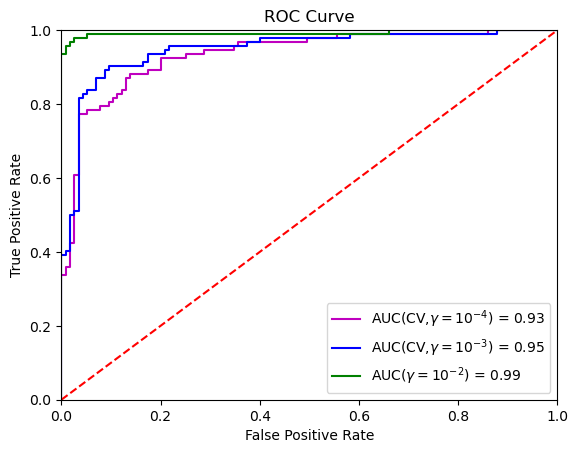

In [16]:
plt.title('Receiver Operating Characteristic') # show two ROC curves on one plot for training set
plt.plot(fpr_train_04, tpr_train_04, 'm', label = 'AUC(CV,$\gamma = 10^{-4}$) = %0.2f' % auc_train_04)
plt.plot(fpr_train_CV, tpr_train_CV, 'b', label = 'AUC(CV,$\gamma = 10^{-3}$) = %0.2f' % auc_train_CV)
plt.plot(fpr_train_02, tpr_train_02, 'g', label = 'AUC($\gamma = 10^{-2}$) = %0.2f' % auc_train_02)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

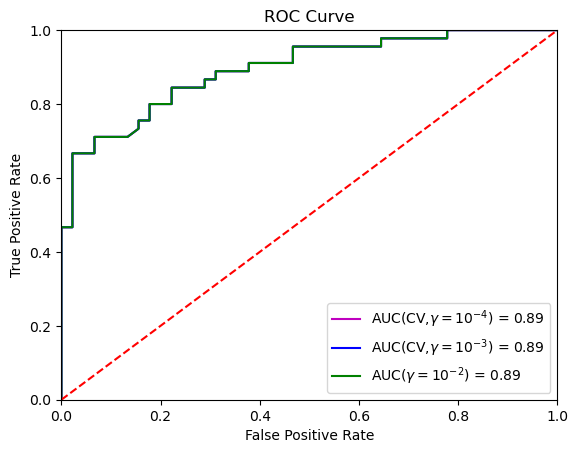

In [17]:
plt.title('Receiver Operating Characteristic') # show two ROC curves on one plot for test set
plt.plot(fpr_test_04, tpr_test_04, 'm', label = 'AUC(CV,$\gamma = 10^{-4}$) = %0.2f' % auc_test_04)
plt.plot(fpr_test_CV, tpr_test_CV, 'b', label = 'AUC(CV,$\gamma = 10^{-3}$) = %0.2f' % auc_test_CV)
plt.plot(fpr_test_02, tpr_test_02, 'g', label = 'AUC($\gamma = 10^{-2}$) = %0.2f' % auc_test_02)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()
# note here green and magenta lines coincide with each other